# CSYS5040 Tutorial for time-series analysis of EEG Data

### Annie Bryant
### 17 September 2024

In [98]:
# Install required packages if needed
!pip install pycatch22 pyspi numpy pandas seaborn matplotlib rpy2

# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pycatch22
from pyspi.calculator import Calculator
import seaborn as sns
from copy import deepcopy

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [44]:
%%R 
suppressPackageStartupMessages({
    library(cowplot)
    library(ggseg)
    library(ggsegYeo2011)
    library(patchwork)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

In [18]:
# info about example_array.npy
# Sample_ID: Train_1
# cortical: negativity

# Load in the example EEG time-series data
fMRI_resting_data = np.load('fMRI_resting_data.npy')

# The 7 rows represent seven resting-state networks of brain activity, while the 947 coumns represent timepoints
# Let's print the first five rows (brain networks) and columns (timepoints) of the resting-state fMRI time-series data
print(fMRI_resting_data[0:5, 0:5])

[[-0.95429605 -0.96895107 -0.47352705 -0.58280167 -0.22510818]
 [-1.37612159 -0.61024501 -0.33130259  1.9982668   1.23660763]
 [ 2.12000844  1.83853096 -0.1088877   1.60167371  1.42746935]
 [-0.49252915  0.95369168 -0.12480374  3.15599038  2.57502518]
 [ 1.42835683  1.27789451  0.50976466 -0.98587253 -1.19162177]]


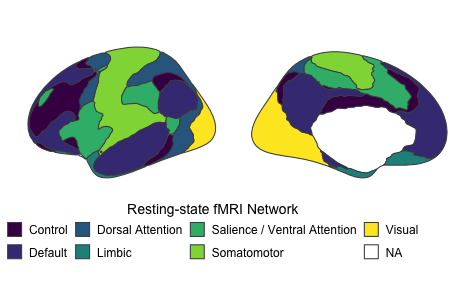

In [54]:
%%R  -w 475 -h 300

ggseg(atlas = yeo7, mapping = aes(fill = region), hemisphere="left", color="gray30") +
#   scale_fill_brain("yeo7", package = "ggsegYeo2011") +
  theme_cowplot() +
  labs(fill="Resting-state fMRI Network") +
  theme(axis.title = element_blank(),
        axis.text = element_blank(),
        axis.line = element_blank(),
        axis.ticks = element_blank(),
        legend.position = "bottom") +
  scale_fill_viridis_d() +
  guides(fill = guide_legend(nrow = 2, title.position="top", title.hjust = 0.5))

In [61]:
# Let's convert this to a Pandas DataFrame for easier manipulation
fMRI_resting_data_df = pd.DataFrame(fMRI_resting_data)

# Define networks
brain_networks = ["Control", "Default", "DorsalAttention", "Limbic", "Somatomotor", "VentralAttention", "Visual"]

# Assign column for networks
fMRI_resting_data_df['Brain_Network'] = brain_networks

# Pivot from wide to long
fMRI_resting_data_df = fMRI_resting_data_df.melt(id_vars='Brain_Network', var_name='Timepoint', value_name='Signal')
fMRI_resting_data_df.head()

,Brain_Network,Timepoint,Signal
0,Control,0,-0.954296
1,Default,0,-1.376122
2,DorsalAttention,0,2.120008
3,Limbic,0,-0.492529
4,Somatomotor,0,1.428357


Text(0, 0.5, 'BOLD Signal')

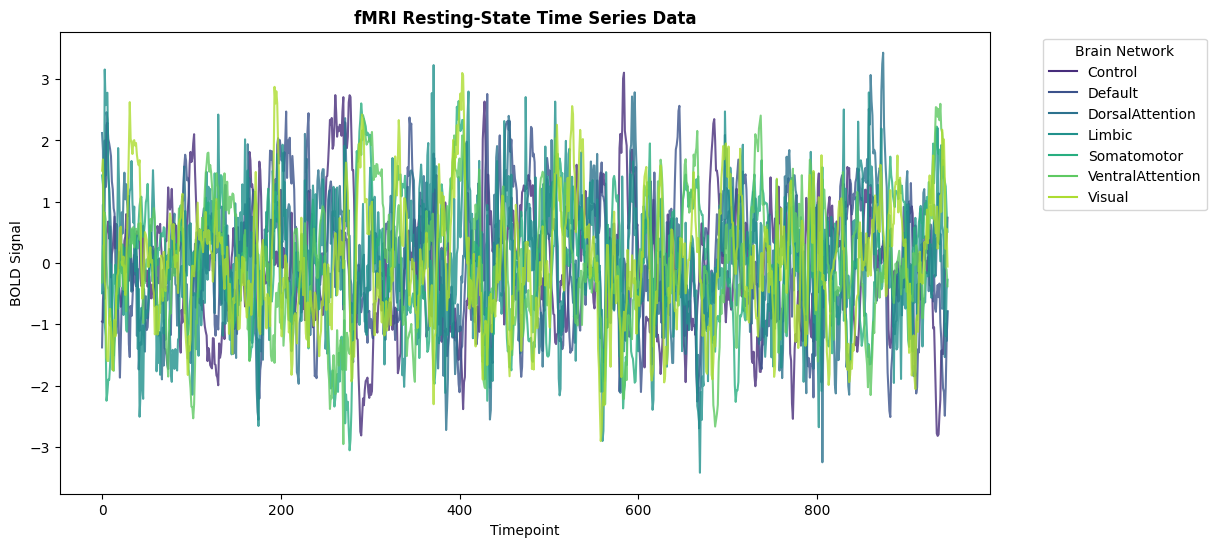

In [55]:
# Visualize the time series as line plots with a Viridis color palette
plt.figure(figsize=(12, 6))
sns.lineplot(data=fMRI_resting_data_df, x='Timepoint', y='Signal', hue='Brain_Network', palette='viridis', alpha=0.8)

# Set title
plt.title('fMRI Resting-State Time Series Data', fontweight='bold')

# Put legend on outside with two columns
plt.legend(title='Brain Network', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set x and y axis titles
plt.xlabel('Timepoint')
plt.ylabel('BOLD Signal')

Text(120.72222222222221, 0.5, 'Brain Network')

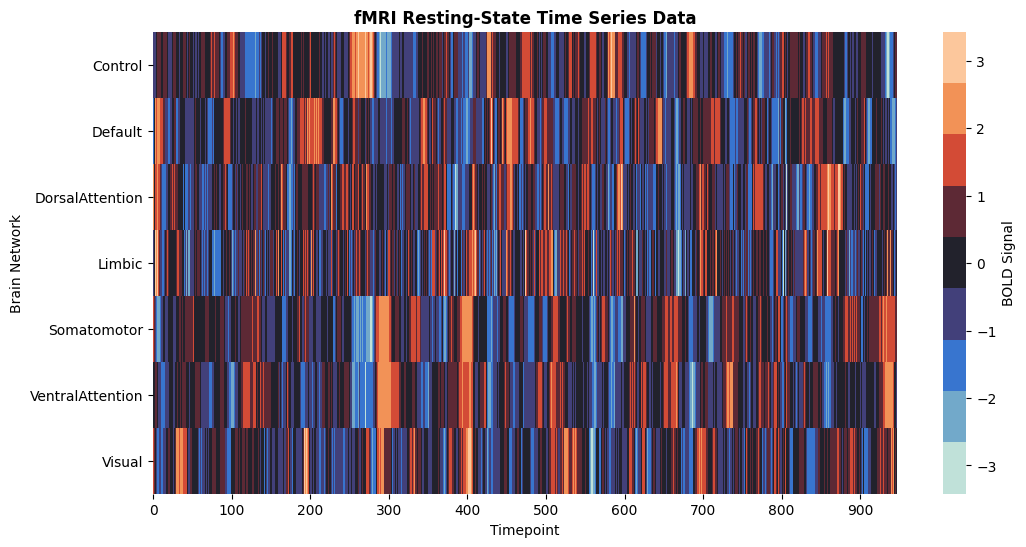

In [38]:
# Plot as a MTS heatmap
plt.figure(figsize=(12, 6))
# Create an array with the colors you want to use
colors = ["#C0E1D9", "#72A9CA", "#3875CF", "#42407A", "#22222C", "#5D2935", "#D34B36", "#F29257", "#FCC79C"]
sns.heatmap(fMRI_resting_data, cmap=sns.color_palette(colors), xticklabels=100, cbar_kws={'label': 'BOLD Signal'})
plt.title('fMRI Resting-State Time Series Data', fontweight='bold')
# Set y-axis text to the brain networks
plt.yticks(ticks=np.arange(0.5, 7.5, 1), labels=["Control", "Default", "DorsalAttention", "Limbic", "Somatomotor", "VentralAttention", "Visual"], rotation=0)
plt.xlabel('Timepoint')
plt.ylabel('Brain Network')

### Univariate time-series feature analysis with catch22

In [85]:
# Compute catch22 features for each row of fMRI_resting_data
fMRI_resting_catch22_res = np.apply_along_axis(pycatch22.catch22_all, 1, fMRI_resting_data, short_names=True)
fMRI_resting_catch22_res_list = []

# Iterate over each network and extract the catch22 features
for network_index in range(7):
    brain_network = brain_networks[network_index]
    catch22_features = fMRI_resting_catch22_res[network_index]
    network_catch22_df = (pd.DataFrame(catch22_features)
                          .assign(Brain_Network=brain_network)
                          .rename(columns={"short_names": "catch22_feature", "values": "feature_value"})
                          .drop(columns='names'))

    # Append to list
    fMRI_resting_catch22_res_list.append(network_catch22_df)

# Concatenate the list of DataFrames into a single DataFrame
fMRI_resting_catch22_df = pd.concat(fMRI_resting_catch22_res_list)

/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


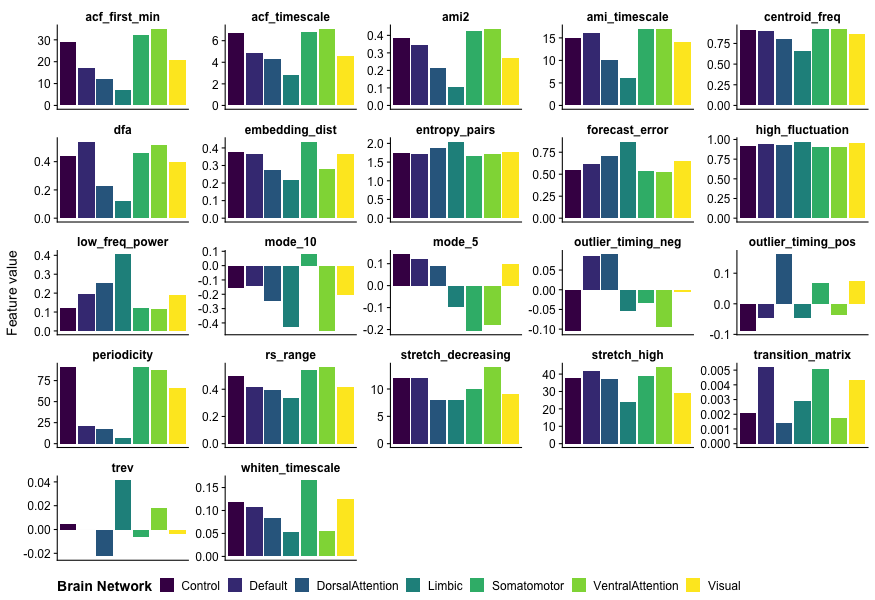

In [95]:
%%R -i fMRI_resting_catch22_df -w 875 -h 600

fMRI_resting_catch22_df %>%     
    ggplot(data=., mapping=aes(x=Brain_Network, y=feature_value, fill=Brain_Network)) +
    geom_bar(stat="identity") +
    facet_wrap(catch22_feature ~ ., scales="free", ncol=5) +
    theme(axis.text.x = element_blank()) +
    ylab("Feature value") +
    labs(fill="Brain Network") +
    guides(fill=guide_legend(nrow=1)) +
    scale_fill_viridis_d() +
    theme(legend.position="bottom",
          axis.ticks.x = element_blank(),
          axis.title.x = element_blank(),
          legend.title = element_text(face='bold'),
          strip.background = element_blank(),
          strip.text = element_text(face='bold'))

### Bivariate time-series feature analysis with pyspi

In [110]:
SPI_info = pd.read_csv("pairwise_feature_info.csv")


# Initialize a Calculator object
calc = Calculator(subset='sonnet', dataset=fMRI_resting_data)
calc.compute()

In [113]:
# Save SPI results 
SPI_res = deepcopy(calc.table)

# Iterate over each SPI
SPI_res.columns = SPI_res.columns.to_flat_index()

# Convert index to column
SPI_res.reset_index(level=0, inplace=True)

# Rename index as first brain region
SPI_res = SPI_res.rename(columns={"index": "network_from"})

# Pivot data from wide to long
SPI_res_long = pd.melt(SPI_res, id_vars="network_from")
SPI_res_long['SPI'], SPI_res_long['network_to'] = SPI_res_long.variable.str

# Remove variable column
pyspi_results_df = SPI_res_long.drop(columns=["variable"])

# Remove where element_from == element_to
pyspi_results_df = pyspi_results_df.query('network_from != network_to')

# Map proc name to brain network
fMRI_proc_lookup_table = pd.DataFrame({"proc": ["proc-0", "proc-1", "proc-2", "proc-3", "proc-4", "proc-5", "proc-6"],
                                        "Node": ["Control", "Default", "DorsalAttention", "Limbic", "Somatomotor", "VentralAttention", "Visual"]})

# Merge lookup table with SPI results
pyspi_results_df = pyspi_results_df.merge(fMRI_proc_lookup_table, left_on='network_from', right_on='proc', how='left').drop(columns=["proc", "network_from"]).rename(columns={"Node": "Network_From"})
pyspi_results_df = pyspi_results_df.merge(fMRI_proc_lookup_table, left_on='network_to', right_on='proc', how='left').drop(columns=["proc", "network_to"]).rename(columns={"Node": "Network_To"})

# Merge with SPI_info
pyspi_results_df = pyspi_results_df.merge(SPI_info, left_on="SPI", right_on="pyspi_name", how="left").drop(columns=["SPI", "pyspi_name", "Feature_description", "Module"])

Columnar iteration over characters will be deprecated in future releases.


In [114]:
# Let's view the first five rows of the pyspi results
pyspi_results_df.head()

,value,Network_From,Network_To,Figure_name,Literature_Category,Directed
0,0.215185,Default,Control,Pearson,Basic statistics,No
1,-0.035829,DorsalAttention,Control,Pearson,Basic statistics,No
2,-0.209136,Limbic,Control,Pearson,Basic statistics,No
3,-0.735116,Somatomotor,Control,Pearson,Basic statistics,No
4,-0.823438,VentralAttention,Control,Pearson,Basic statistics,No


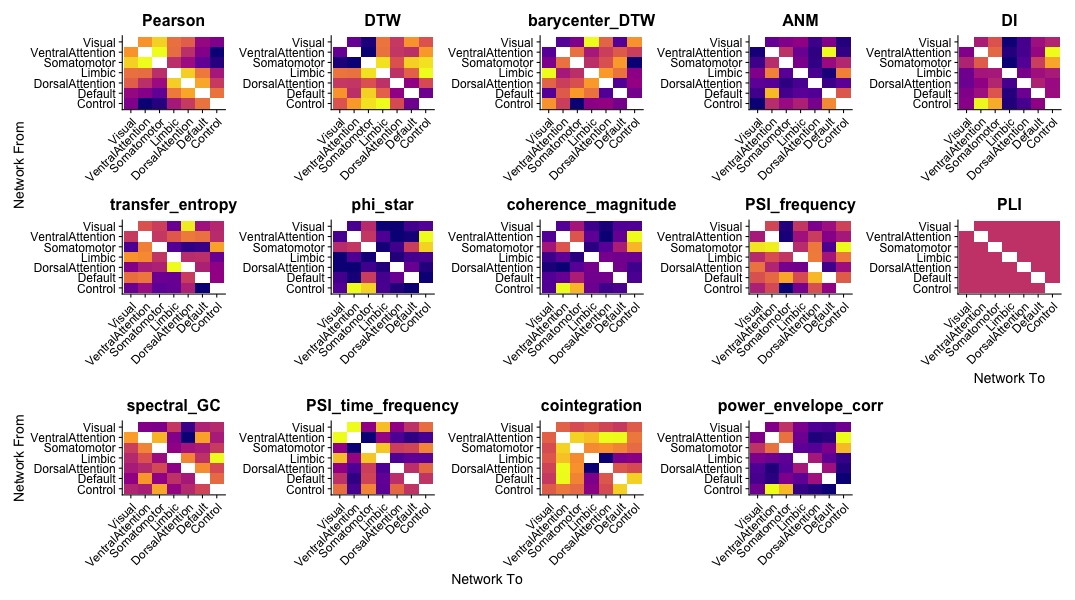

In [119]:
%%R -i pyspi_results_df -w 1075 -h 600
# Let's visualize the SPI results as heatmaps, one per SPI

# Rows = network from, columns = network to, fill = SPI value
SPI_heatmap_list <- list()
for (this_SPI in unique(pyspi_results_df$Figure_name)) {
    SPI_plot <- pyspi_results_df %>%
        filter(Figure_name == this_SPI) %>%
        ggplot(data=., mapping=aes(x=Network_To, y=Network_From, fill=value)) +
        scale_x_discrete(limits=rev) +
        geom_tile() +
        scale_fill_viridis_c(option="plasma") +
        ggtitle(this_SPI) +
        ylab("Network From") +
        xlab("Network To") +
        theme(legend.position="none",
              plot.title = element_text(hjust=0.5),
              axis.text.x = element_text(angle=45, hjust=1))

    SPI_heatmap_list[[this_SPI]] <- SPI_plot
}

wrap_plots(SPI_heatmap_list, ncol=5) +
  plot_layout(axis_titles = "collect")

